# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

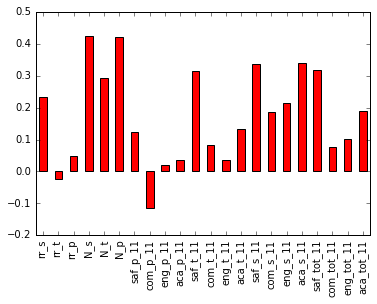

In [31]:
%matplotlib inline
combined.corr()['sat_score'][survey_fields].plot.bar(color='r')

### Findings
#### •N_s: Number of student respondents and N_p: Number of parent respondents have a high correlation with SAT scores. It is prudent to infer that parent, as well as student involvement, equates to higher academic achievement.
#### •saf: Safety and Respect scores based on how safe the learning environment is perceived by student and teachers is another highly correlated factor in doing well academically.
#### •From aca_s_11: how a student perceives academic standards is positively correlated with high SAT scores. It makes sense that parent and teachers' perceptions do not affect the outcome.

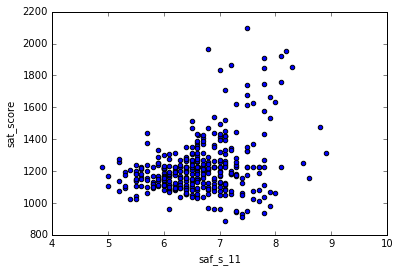

In [12]:
combined.plot.scatter('saf_s_11', 'sat_score')

### Findings
#### •Weak correlation between student perceived safety and SAT scores. Schools are clustered in a range of 5.5 to 7 for safety scores but with varied SAT scores.
#### •There are some outlying schools with high SAT scores and high safety perception scores.
#### •Perhaps data collection method of perceived safety could be revised for more accuracy.

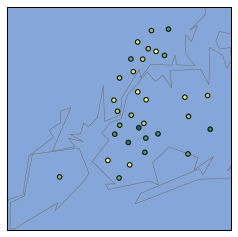

In [13]:
import matplotlib.pyplot as plt
import numpy
districts = combined.groupby('school_dist').agg(numpy.mean)
combined['school_dist'] = districts.reset_index(inplace=True)

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=districts['saf_s_11'], cmap="summer")
plt.show()

### Findings
#### •Brooklyn has higher safety scores.
#### •Queens, Bronx and Upper Manhattan have lower scores.

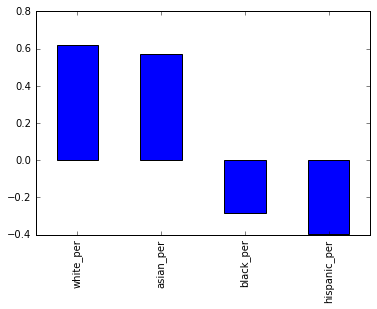

In [14]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()['sat_score'][race_cols].plot.bar()

### Findings
#### •Positive correlation between percentage of white and asian and SAT scores.
#### •The high positive correlation of percentage asian challenges the assumption that the SAT is racially biased against minorities.
#### •Race and SAT scores might be a spurious correlation. A likely confounding variable might be socio-economics.

In [15]:
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### Findings
#### •The above list of schools have high enrollment of ESL immigrant students which would explain the low SAT scores.
#### •This reveals that low language comprehension might the confounding variable for low SAT scores.

In [16]:
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### Findings
#### •These are well funded schools. Students get extra help hence higher SAT scores.
#### •This reveals that socio-economics is a crucial factor for high SAT scores.

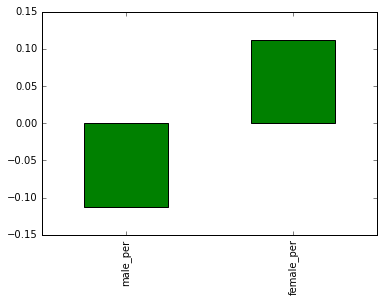

In [30]:
gender_per = ['male_per', 'female_per']
combined.corr()['sat_score'][gender_per].plot.bar(color='g')

### Findings
#### •Weak negative correlation between male percentages at schools and low SAT scores.
#### •Weak positive correlation between female percentages at schools and high SAT scores.

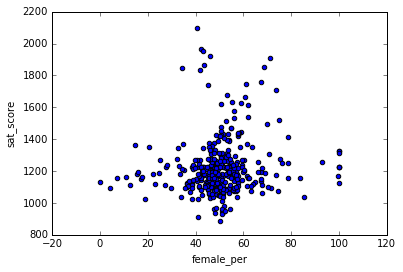

In [32]:
combined.plot.scatter('female_per', 'sat_score')

### Findings
#### •No obvious correlation bewteen female percentages in schools and SAT scores.
#### •The cluster range for high (as well as low) SAT scores seems to be 40-70+ percent.

In [33]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

1. These schools have high academic standards and are selective. Hence they have high SAT scores.

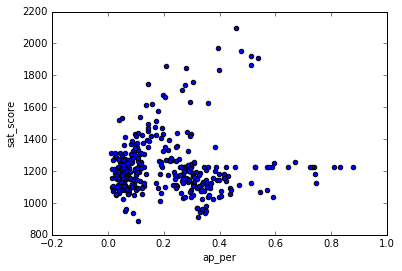

In [36]:
ap_per = (combined['AP Test Takers '])/(combined['total_enrollment'])
combined['ap_per'] = ap_per
combined.plot.scatter('ap_per', 'sat_score')

### Findings
#### •There is a cluster of schools at the 40 -60 percent range that suggests a weak positive correlation between AP test taking percentage and SAT scores.
#### •However there are low SAT scores in the 30-40 percent range.
#### •Schools at the 60-100 percent range with 1200+ SAT scores might negate any correlation between AP test taking percentages and SAT scores because SAT scores remain in the 1200+ range even though AP test taking pecentages approach 100 percent.